# 1. Data and module import

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from datetime import datetime

In [16]:
dataset = pd.read_csv('../timeseries-forecasting/salesdata_ger.csv')
dataset.head(5)

,OrderDate,QtyOrdered
0,2019-01-01,9279
1,2019-01-02,11073
2,2019-01-03,12272
3,2019-01-04,12617
4,2019-01-05,13354


In [17]:
# Convert data into format required by Prophet

dataset_train = dataset.query("OrderDate <= '2021-12-31'")
df = pd.DataFrame({'ds': pd.to_datetime(dataset_train['OrderDate']), 'y': dataset_train['QtyOrdered']})
df.tail(5)

,ds,y
1091,2021-12-27,31431
1092,2021-12-28,29659
1093,2021-12-29,28661
1094,2021-12-30,24712
1095,2021-12-31,15377


# 2. Model creation and fitting

In [18]:
# Declare black_fridays and paydays df to input as parameter to the model

black_fridays = pd.DataFrame({'holiday': 'Black Friday',
                              'ds': pd.to_datetime(['2019-11-29', '2020-11-27', '2021-11-25', '2022-11-25']),
                              'lower_window': 0,
                              'upper_window': 2})

paydays = pd.DataFrame({'holiday': 'Pay Day',
                        'ds': pd.date_range('2019-01-01','2022-12-31', freq='D'),
                        'lower_window': 0})


# Leave only 26th and 11th day of the month - there is always a spike around this day, except for February where 16th is the spike
paydays = paydays[(paydays['ds'].dt.day == 1) | (paydays['ds'].dt.day == 10)]

# Define upper windows for particular days
def upper_window(row):
    if row.day == 1:
        return 2
    if row.day == 10:
        return 1
    
paydays['upper_window'] = np.NaN
paydays['upper_window'] = paydays['ds'].apply(upper_window)
paydays.drop_duplicates(inplace=True)
paydays.reset_index(drop=True, inplace=True)

paydays

,holiday,ds,lower_window,upper_window
0,Pay Day,2019-01-01,0,2
1,Pay Day,2019-01-10,0,1
2,Pay Day,2019-02-01,0,2
3,Pay Day,2019-02-10,0,1
4,Pay Day,2019-03-01,0,2
...,...,...,...,...
91,Pay Day,2022-10-10,0,1
92,Pay Day,2022-11-01,0,2
93,Pay Day,2022-11-10,0,1
94,Pay Day,2022-12-01,0,2


In [19]:
# Declare final holiday dataframe by concatenating black_fridays and paydays

holidays = pd.concat(objs=[black_fridays, paydays], axis=0, ignore_index=True)
holidays

,holiday,ds,lower_window,upper_window
0,Black Friday,2019-11-29,0,2
1,Black Friday,2020-11-27,0,2
2,Black Friday,2021-11-25,0,2
3,Black Friday,2022-11-25,0,2
4,Pay Day,2019-01-01,0,2
...,...,...,...,...
95,Pay Day,2022-10-10,0,1
96,Pay Day,2022-11-01,0,2
97,Pay Day,2022-11-10,0,1
98,Pay Day,2022-12-01,0,2


In [20]:
# Initialize and fit Prophet model with holidays parameter
prophet = Prophet(holidays=holidays)
prophet.add_country_holidays(country_name='DE')
prophet.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
# Declare future timeline

future = prophet.make_future_dataframe(periods=365, freq='D')
future.tail()

,ds
1456,2022-12-27
1457,2022-12-28
1458,2022-12-29
1459,2022-12-30
1460,2022-12-31


In [22]:
# Forecast. yhat - predicted value, yhat_upper - upper interval, yhat_lower - lower interval

forecast = prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-01-01,7720.988288,612.641534,15522.168943
1,2019-01-02,9240.149371,1823.954507,17850.301584
2,2019-01-03,7981.532371,320.328456,16484.551654
3,2019-01-04,6153.985802,-1665.225201,14723.317377
4,2019-01-05,8464.419914,851.735388,16749.727739


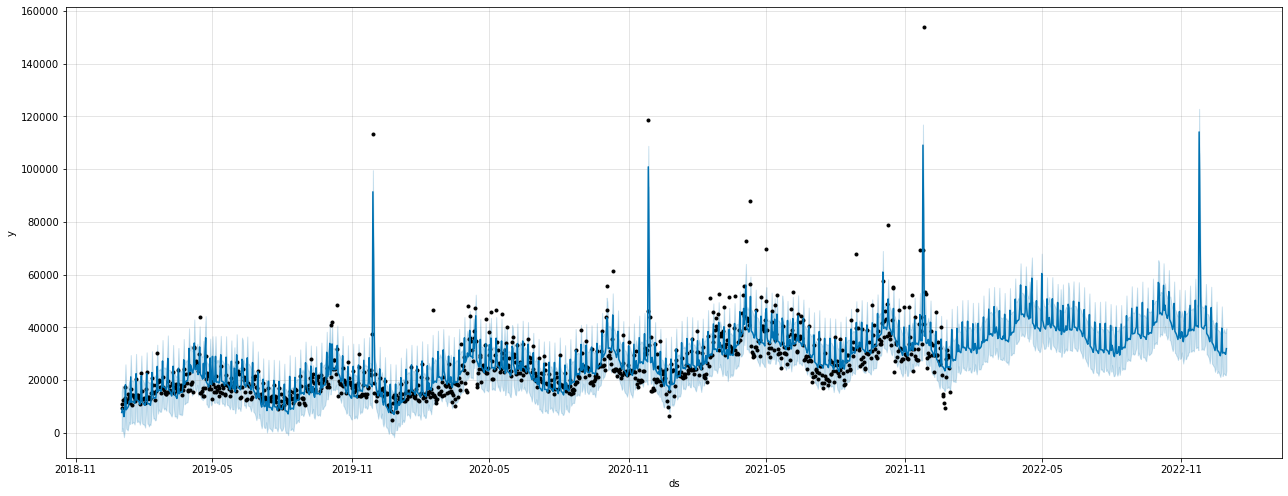

In [23]:
fig = prophet.plot(forecast, figsize=(18,7))

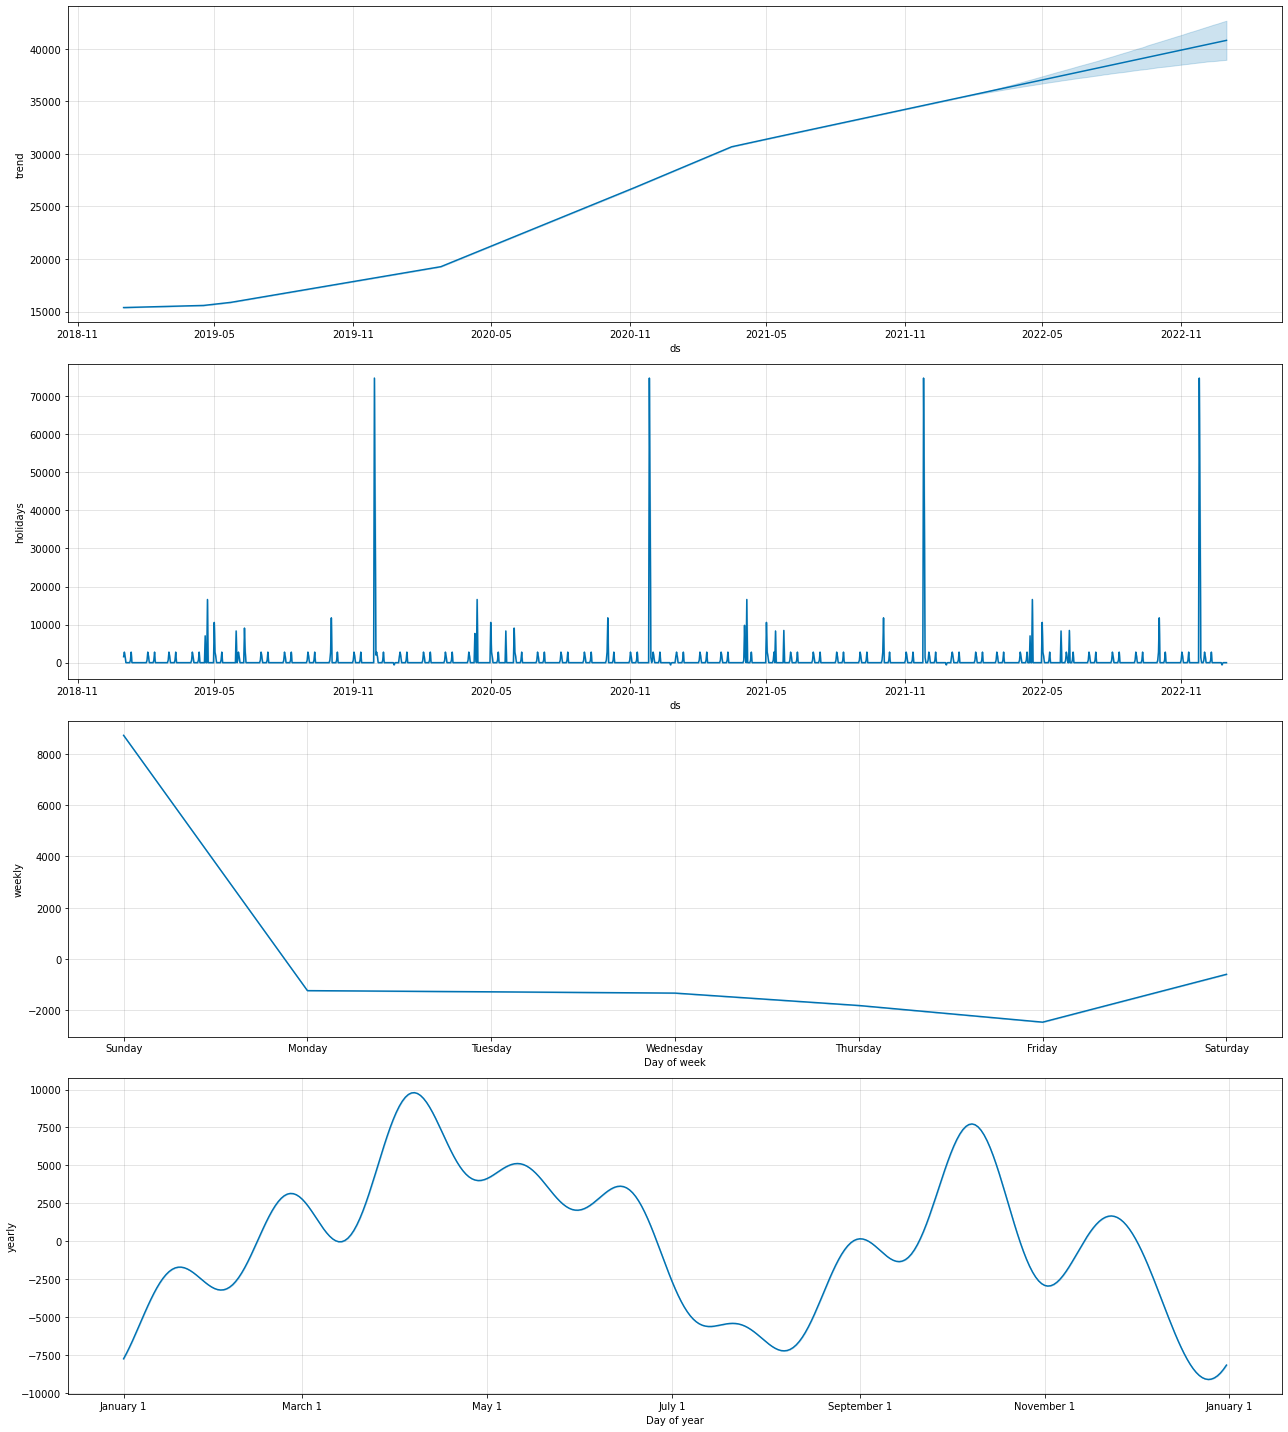

In [24]:
fig2 = prophet.plot_components(forecast, figsize=(18,20))

# 3. Model validation

In [25]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet.diagnostics import cross_validation

initial = len(dataset_train)


cv_results = cross_validation(prophet, horizon='7 days', period='14 days')


INFO:prophet:Making 52 forecasts with cutoffs between 2020-01-10 00:00:00 and 2021-12-24 00:00:00


  0%|          | 0/52 [00:00<?, ?it/s]

In [26]:
mae = mean_absolute_error(cv_results.y, cv_results.yhat)
mae

4512.952197041049

In [27]:
cv_results.head(30)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-01-11,14871.300092,10917.803219,19119.232459,15270,2020-01-10
1,2020-01-12,19912.005846,15302.687862,24172.644156,19327,2020-01-10
2,2020-01-13,14060.288136,9788.752200,18157.997514,12957,2020-01-10
3,2020-01-14,14280.316003,9804.558643,18625.823155,13819,2020-01-10
4,2020-01-15,14468.862937,10048.992353,18701.114638,15903,2020-01-10
5,2020-01-16,14269.795997,10304.550307,18356.517925,13879,2020-01-10
6,2020-01-17,12631.056666,8416.229423,16753.965998,13797,2020-01-10
7,2020-01-25,15043.943508,11010.502379,18988.226056,16594,2020-01-24
8,2020-01-26,21079.278065,17181.413244,25384.722032,23949,2020-01-24
9,2020-01-27,15015.754074,11246.666104,19478.266698,18244,2020-01-24


In [28]:
mape = mean_absolute_percentage_error(cv_results.y, cv_results.yhat)
mape

0.1630682076712772